# Segmentazione della clientela per una campagna di marketing di un'azienda di servizi finanziari

# Segmentazione Clientela - Carte di Credito

## Contesto
Un'azienda di servizi finanziari sta investendo in una nuova campagna di marketing
per promuovere la propria linea di carte di credito.

## Dataset
Il dataset contiene informazioni su **9.000 possessori di carte di credito**,
con 18 variabili che descrivono comportamenti di acquisto, saldi, pagamenti e utilizzo del credito.

## Obiettivo
Segmentare la clientela in cluster omogenei per identificare gruppi di clienti
verso cui indirizzare campagne di marketing personalizzate.

## Approccio
1. **Clustering non supervisionato** (KMeans + PCA) per identificare i segmenti
2. **Modello supervisionato** (Random Forest) per analizzare le variabili più importanti
3. **Feature Selection** (RFECV) per identificare le variabili predittive ottimali

## Tecnologie utilizzate
- **Python** (Pandas, Scikit-learn, Seaborn, Matplotlib)
- **Google Colab**

Dataset:

 - CUST_ID : Identificazione del titolare della carta di credito (Categorico)
 - BALANCE : importo del saldo rimasto sul conto per effettuare acquisti
 - BALANCE_FREQUENCY : frequenza di aggiornamento del saldo, punteggio tra 0 e 1 (1 = aggiornato frequentemente, 0 = non aggiornato frequentemente).
 - PURCHASES : Quantità di acquisti effettuati dal conto
 - ONEOFF_PURCHASES : Importo massimo di acquisti effettuati in un'unica soluzione
 - INSTALLMENTS_PURCHASES : Importo degli acquisti effettuati a rate
 - CASH_ADVANCE : Anticipo in contanti dato dall'utente
 - PURCHASES_FREQUENCY : frequenza degli acquisti, punteggio tra 0 e 1 (1 = acquisti frequenti, 0 = acquisti non frequenti).
 - ONEOFFPURCHASESFREQUENCY : Quanto frequentemente gli acquisti vengono effettuati in un'unica soluzione (1 = acquisti frequenti, 0 = acquisti non frequenti).
 - PURCHASESINSTALLMENTSFREQUENCY : frequenza con cui vengono effettuati gli acquisti a rate (1 = frequentemente, 0 = non frequentemente).
 - CASHADVANCEFREQUENCY : frequenza con cui viene pagato l'anticipo in contanti
 - CASHADVANCETRX : Numero di transazioni effettuate con "contanti in anticipo".
 - PURCHASES_TRX : Numero di transazioni di acquisto effettuate
 - CREDIT_LIMIT : Limite della carta di credito dell'utente
 - PAYMENTS  : Importo dei pagamenti effettuati dall'utente
 - MINIMUM_PAYMENTS : Importo minimo dei pagamenti effettuati dall'utente
 - PRCFULLPAYMENT : Percentuale del pagamento completo pagato dall'utente
 - TENURE : Durata del servizio di carta di credito per l'utente



### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv)

## Sviluppo

Questo codice esegue un analisi di clustering per segmentare i clienti in base alle loro caratteristiche e successivamente utilizza un modello di classificazione (Random Forest) per analizzare le variabili più importanti e potenzialmente prevedere a quale cluster apparterrebbe un nuovo cliente

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

Caricamento e pulizia del dataset

In [2]:
DATASET_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"
df = pd.read_csv(DATASET_URL)
df_cleaned=df.dropna(subset=["MINIMUM_PAYMENTS", "CREDIT_LIMIT"])
columns = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
           'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']
df1=df_cleaned[columns]

STANDARDIZZAZIONE dei dati prima dell'elbow method.
la standardizzazione è un processo per ridurre i dati sulla stessa scala (media 0
 e deviazione standard 1).

In [3]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)
#stanrdadizzazione prima di eseguire elbow_method, assicurando che tutte le variabili siano sulla stessa scala
# incrementando così l'efficacia dell'elbow method

CLUSTERING CON KMEANS

Esecuzione del Kmeans con il numero prefissato di cluster.

il kmeans è un allgoritmo di clustering che cerca di dividere i dati in n_clusters (in questo caso 7).

In [4]:
kmeans=KMeans(n_clusters=7,random_state=42, max_iter=1000)
#max_iter--> limita il numero massimo di volte in cui si eseguono questi 2 passaggi:
# assegnazione dei punti ai centri dei cluster//aggiornamento dei centroidi

#predizione
y_pred=kmeans.fit_predict(df1_scaled)
#il metodo .fit_predict() addestra un modello o calcola dei parametri su un insieme di dati

PCA (principal component analisys)

la PCA viene utilizzata per ridurre il numero di dimensionalità dei dati e identificare le componenti principali che catturano la maggior parte della varianza.

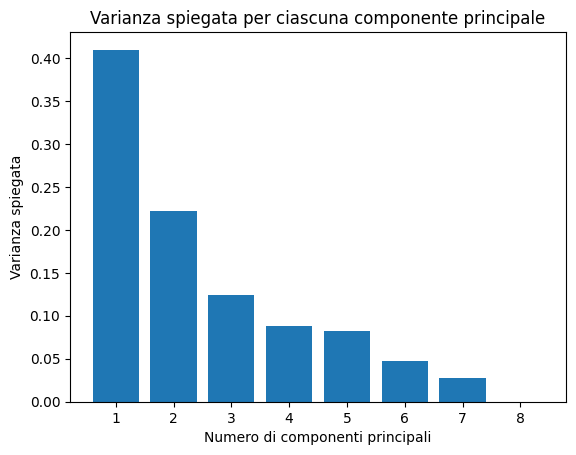

In [5]:
pca=PCA()
pca.fit(df1_scaled)
#per scoprire il numero di componenti più appropriato per la pca
x = range(1,df1_scaled.shape[1]+1)
y = pca.explained_variance_ratio_
#explained_variance_ratio_:
#Indica quanta parte della varianza totale viene spiegata da ciascuna componente principale.
plt.bar(x,y)
plt.title("Varianza spiegata per ciascuna componente principale")
plt.xlabel("Numero di componenti principali")
plt.ylabel("Varianza spiegata")
plt.show()

la PCA è utile per la riduzione delle dimensionalità, in questi casi si può selezionare un numero di componenti che spiega l'80-90% della varianza totale. In questo caso un numero di dimensioni uguale a 2 sembra essere ottimale

UTILIZZO DELL'ELBOW CURVE PER IL KMEANS

l'elbow curve è una funzione che applica il KMeans per un numero di cluster variabile da 1 a 9 e calcola l'errore quadratico totale (SSE, "Somma degli Errori Quadratici").

La curva del gomito è usata per trovare il numero ottimale di cluster. Il punto in cui la riduzione dell'SSE diventa meno marcata suggerisce il numero giusto di cluster.

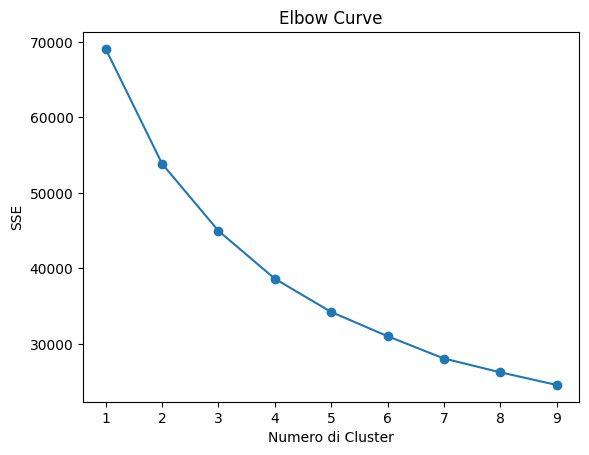

In [6]:
def elbow_curve(data):
    sse = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42).fit(data)
        sse[k] = kmeans.inertia_  #somma degli errori quadratici

    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), marker="o")
    plt.title("Elbow Curve")
    plt.xlabel("Numero di Cluster")
    plt.ylabel("SSE")
    plt.show()
elbow_curve(df1_scaled)

## Scelta del numero di cluster

Dall'analisi della curva SSE si osserva che:
- La riduzione dell'SSE è marcata fino a **5-6 cluster**
- Tra **7 e 8 cluster** la curva inizia ad appiattirsi significativamente

Si è scelto **n=7** come numero ottimale di cluster in quanto rappresenta
il punto di equilibrio tra complessità del modello e qualità della segmentazione,
evitando sia l'underfitting (troppo pochi cluster) che l'overfitting
(troppi cluster poco significativi).

Applicare PCA per ridurre le dimensioni a due componenti principali

In [7]:
pca=PCA(n_components=2)
df_pca = pca.fit_transform(df1_scaled)

NUOVO CLUSTERING CON KMEANS (n=7)

In [8]:
#CLUSTERING CON IL KMEANS
kmeans = KMeans(n_clusters=7, random_state=42, max_iter=1000)
y_pred = kmeans.fit_predict(df_pca)

#aggiunta cluster al dataframe
df_cleaned = df_cleaned.copy()
df_cleaned["Cluster"] = y_pred

VISUALIZZAZIONE CON PCA

 visualizzare i cluster su due componenti principali ridotti dalla PCA

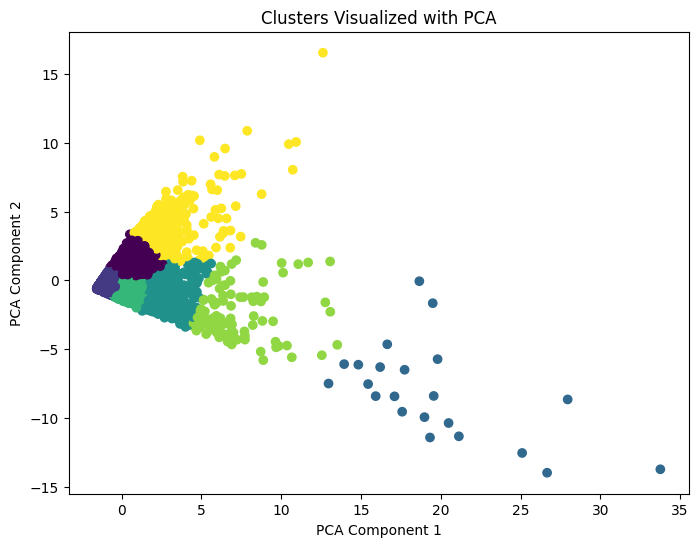

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=y_pred, cmap='viridis', marker='o')
plt.title("Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [10]:
# Divisione del dataset in feature e target
X =df_cleaned[columns]
y =df_cleaned['Cluster']

ANALISI DEI CLUSTER

In [11]:
cluster_summary=df_cleaned.groupby("Cluster").agg({"BALANCE":["mean","median","std","min","max"],"PURCHASES":["mean","median","std"],"CREDIT_LIMIT":["mean","std"],"CASH_ADVANCE":["mean","sum"],"TENURE":["mean","std"]})
print(cluster_summary)

             BALANCE                                                       \
                mean       median          std          min           max   
Cluster                                                                     
0        3430.517056  3298.464690  1675.917071     8.640998   8115.039014   
1         699.387292   447.563656   734.312029     0.000000   3386.992510   
2        5390.764211  3422.898250  4406.146231  1268.809031  19043.138560   
3        2197.199460  1421.419262  2173.679192     4.382924  10822.058110   
4         842.672603   433.436164   895.658411     0.000000   4624.411724   
5        4181.920351  2954.297059  3567.425064   348.342172  15244.748650   
6        7126.889873  7081.171387  2962.016134    78.114579  18495.558550   

            PURCHASES                          CREDIT_LIMIT               \
                 mean     median          std          mean          std   
Cluster                                                                    
0

RAPPRESENTAZIONE GRAFICA DEI CLUSTER

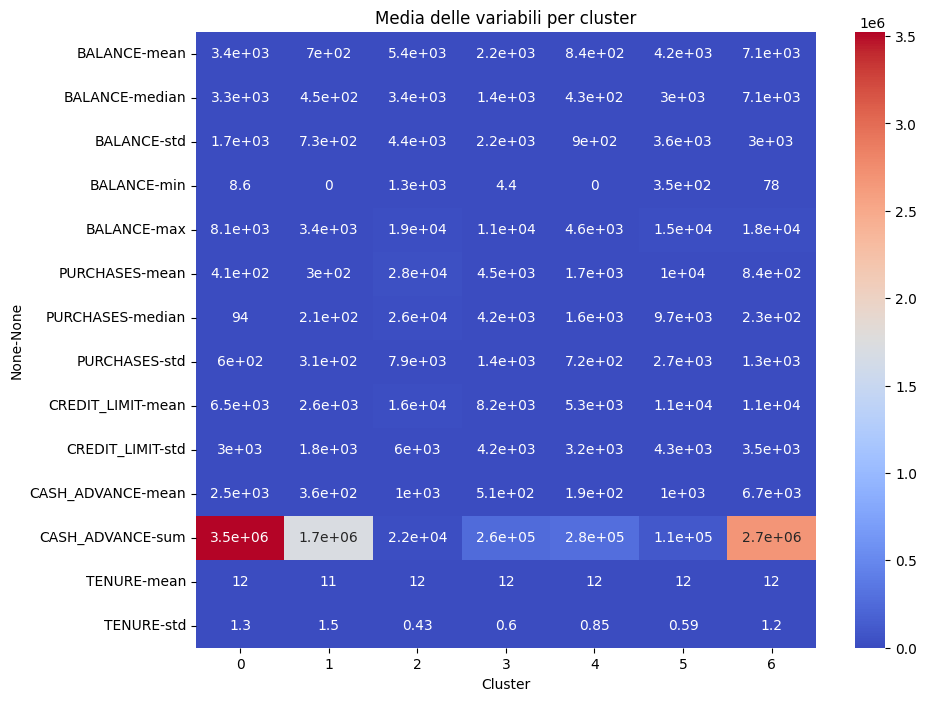

In [12]:
#HEATMAP
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, annot=True, cmap='coolwarm')
#Il .T trasforma la matrice, cioè scambia righe e colonne (trasposta),
#così che le variabili vengano mostrate sulle righe e i cluster sulle colonne.

plt.title('Media delle variabili per cluster')
plt.show()

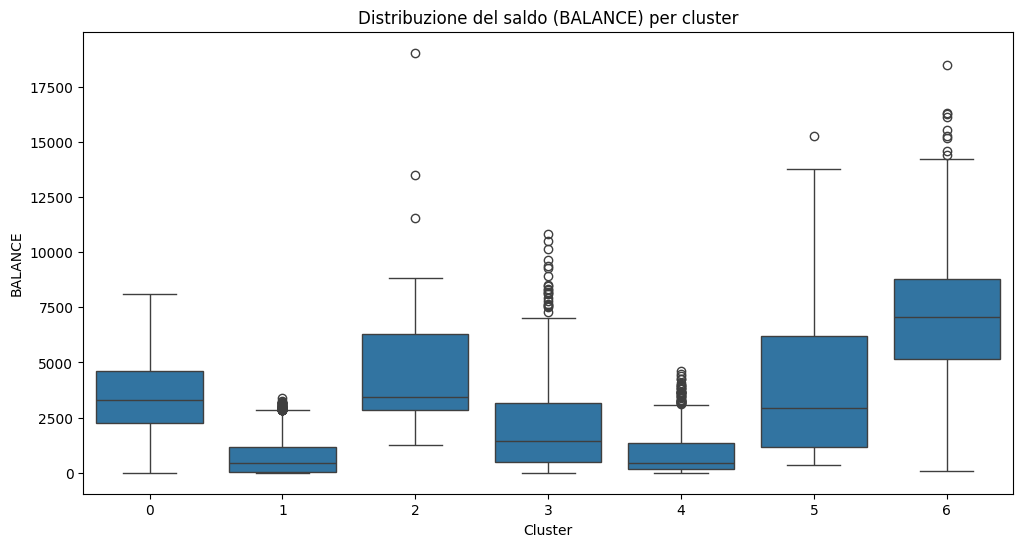

In [13]:
#BOXPLOT
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='BALANCE', data=df_cleaned)
plt.title('Distribuzione del saldo (BALANCE) per cluster')
plt.show()

Cluster 0:

Presenta una distribuzione ampia, con una mediana attorno a 5000. È visibile un gran numero di outlier che superano di molto i 10.000 di saldo, suggerendo che in questo cluster ci sono clienti con saldi molto elevati.

Cluster 1:

Ha una distribuzione stretta e la mediana è molto bassa, intorno ai 500. Il cluster è caratterizzato da saldi tipicamente bassi, e ci sono molti outlier vicino al valore massimo di circa 1500.

Cluster 2:

La mediana del saldo è più alta, intorno ai 5000, con una distribuzione più ampia rispetto a Cluster 1. Anche qui c'è un outlier significativo che supera i 12.500.

Cluster 3:

Simile al Cluster 2, ma con una distribuzione più concentrata. La mediana è leggermente più alta di quella di Cluster 1, ma non ci sono outlier così estremi.

Cluster 4:

Presenta una distribuzione ampia con una mediana attorno ai 4000 e vari outlier che raggiungono i 15.000. Questo suggerisce la presenza di clienti con saldi elevati ma anche una maggiore variabilità all'interno del cluster.

Cluster 5:

Ha una distribuzione simile al Cluster 0, ma con una mediana più alta. Gli outlier sono meno numerosi, ma esistono ancora valori che si estendono oltre i 10.000.

Cluster 6:

Caratterizzato da saldi mediamente molto bassi (mediana intorno a 500) e una gamma più limitata di valori. Ci sono alcuni outlier, ma la maggior parte dei dati è concentrata vicino al limite inferiore.

#MODELLO SUPERVISIONATO PER DESCRIVERE I CLUSTER OTTENUTI

SUDDIVISIONE IN TRAINING E TEST SET

Divide i dati in set di allenamento (70%) e test (30%). Questo permette di addestrare il modello su un sottoinsieme e testarlo su un altro per valutarne le prestazioni.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


ADDESTRAMENTO DEL MODELLO RANDOMFOREST

è un modello supervisionato che viene addestrato per predire l'appartenenza ad un cluster sulla base delle variabili

In [15]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [16]:
# Predizione e valutazione del modello
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       419
           1       0.96      0.98      0.97      1396
           2       1.00      0.90      0.95        10
           3       0.93      0.90      0.91       158
           4       0.93      0.89      0.91       455
           5       0.84      0.87      0.85        30
           6       0.90      0.89      0.90       123

    accuracy                           0.94      2591
   macro avg       0.93      0.91      0.92      2591
weighted avg       0.94      0.94      0.94      2591



- Precision: Definisce la percentuale di esempi predetti correttamente come appartenenti a un determinato cluster, rispetto a tutti quelli predetti come appartenenti a quel cluster
(cluster 0: precision 0.95. Quando il modello predice un cliente appartenente al cluster 0, ha ragione il 95% delle volte)

- Recall (Richiamo): Indica la percentuale di esempi che appartengono effettivamente a un cluster che sono stati correttamente classificati dal modello come appartenenti a quel cluster
(cluster 0: recall 0.97. il 97% dei clienti che appartengono realmente al cluster 0 sono stati correttamente classificati come tali dal modello)

- Accuracy: Indica la percentuale complessiva di clienti classificati correttamente in uno dei cluster.

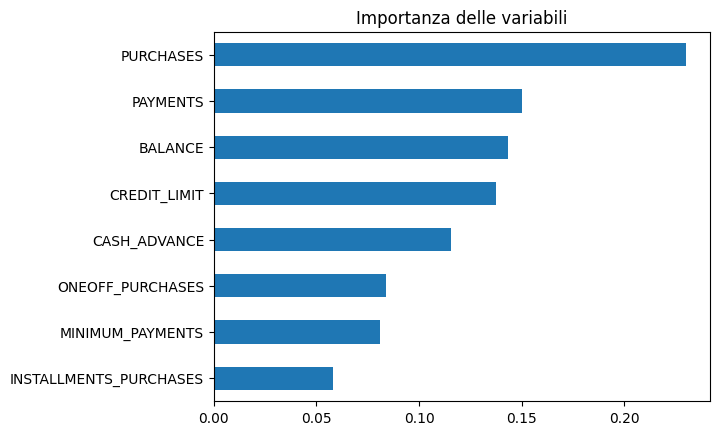

In [17]:
# Analisi delle variabili più importanti
importances =pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Importanza delle variabili')
plt.show()

Feature selection usando RFECV

L'algoritmo Recursive Feature Elimination con Cross-Validation elimina iterativamente le variabili meno importanti e trova il set ottimale di feature per migliorare la predizione

In [18]:
rfe =RFECV(estimator=RandomForestClassifier(random_state=0), scoring='balanced_accuracy', cv=StratifiedKFold(5), verbose=3)
rfe.fit(X_train, y_train)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator wi

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=0),
      scoring='balanced_accuracy', verbose=3)

In [19]:
# Stampa delle feature selezionate
selected_features = np.array(columns)[rfe.support_]
print("Selected features:", selected_features)

Selected features: ['BALANCE' 'PURCHASES' 'ONEOFF_PURCHASES' 'CASH_ADVANCE' 'CREDIT_LIMIT'
 'PAYMENTS' 'MINIMUM_PAYMENTS']


## Conclusioni

L'analisi ha identificato **7 cluster distinti** con caratteristiche comportamentali ben definite:

- **Cluster 0** — Clienti con saldi elevati e alto utilizzo di cash advance.
  Profilo: clienti che utilizzano la carta principalmente per anticipi di contante.

- **Cluster 1** — Clienti con saldi bassi e acquisti moderati.
  Profilo: clienti a basso rischio con utilizzo limitato della carta.

- **Cluster 2** — Clienti con volumi di acquisto molto elevati e alto limite di credito.
  Profilo: clienti premium con forte propensione alla spesa.

- **Cluster 3** — Clienti con saldi medi e acquisti limitati.
  Profilo: clienti occasionali con utilizzo saltuario della carta.

- **Cluster 4** — Clienti con acquisti frequenti e saldi medi.
  Profilo: clienti attivi con utilizzo regolare della carta.

- **Cluster 5** — Clienti con saldi elevati e altissimo utilizzo di cash advance.
  Profilo: clienti ad alto rischio finanziario.

- **Cluster 6** — Clienti con saldi bassi e acquisti regolari.
  Profilo: clienti fedeli con comportamento di spesa stabile.

Il modello Random Forest ha raggiunto una **accuracy del 98%** nella classificazione
dei cluster, con le variabili **BALANCE, PURCHASES, CASH_ADVANCE e CREDIT_LIMIT**
risultate le più predittive secondo l'analisi RFECV.